In [1]:
import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50


btc_data_path = "../data_store/ticker_data/"\
        "BTCUSDT 1d_2017-08-17 00:00:00_2021-12-14 00:00:00.csv"
btc_df = pd.read_csv(btc_data_path)
btc_df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,datetime
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,1503014399999,3.454770e+06,3427,616.248541,2.678216e+06,8733.911395,2017-08-17 00:00:00
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,1503100799999,5.086958e+06,5233,972.868710,4.129123e+06,9384.141409,2017-08-18 00:00:00
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1503187199999,1.549484e+06,2153,274.336042,1.118002e+06,9184.085529,2017-08-19 00:00:00
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1503273599999,1.930364e+06,2321,376.795947,1.557401e+06,10125.414084,2017-08-20 00:00:00
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,1503359999999,2.797232e+06,3972,557.356107,2.255663e+06,11706.769970,2017-08-21 00:00:00


In [2]:
# unmodified copy for later use
source_df = btc_df.copy()

### BTCUSDT from 2017-2021

In [3]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode


init_notebook_mode(connected=True) 

def candlestick_plot(df):
    fig = go.Figure(data=[go.Candlestick(x=df['datetime'],
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close'])])
    fig.show()

candlestick_plot(btc_df)

### Problem formulation

This notebook to test if historical price and volume information can be helpful to predict +ve/-ve return over the next **3 days**. 

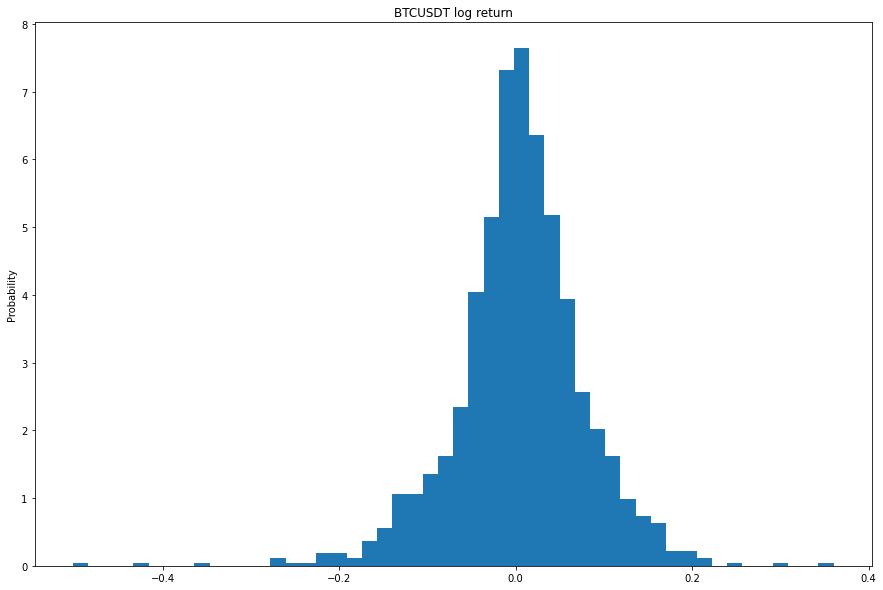

In [4]:
import numpy as np
import matplotlib.pyplot as plt


btc_df["log_return"] = btc_df["close"].map(np.log).shift(periods=-3) - \
                        btc_df["close"].map(np.log)
btc_df["up or down"] = (btc_df["log_return"] > 0).astype(int)
plt.figure(figsize=(15, 10))
plt.hist(btc_df["log_return"], bins=50, density=True)
plt.title("BTCUSDT log return")
plt.ylabel("Probability")
plt.show()

### Technical indicators

In [5]:
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volume import AccDistIndexIndicator
from ta.volatility import BollingerBands


def add_technical_indicators(df,
                   rsi_window=14, 
                   macd_window_slow=26, 
                   macd_window_fast=12, 
                   macd_window_sign=9, 
                   bollinger_window=20, 
                   bollinger_window_dev=2, 
                  ):
    # compares the magnitude of recent gains and losses 
    # over a specified time period to measure speed and 
    # change of price movements of a security
    df["rsi"] = RSIIndicator(df["close"], window=rsi_window).rsi()
    
    # trend-following momentum indicator that shows the 
    # relationship between two moving averages of prices
    macd = MACD(df["close"],
                 window_slow=macd_window_slow, 
                 window_fast=macd_window_fast, 
                 window_sign=macd_window_sign, 
                )
    df["macd_line"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_diff"] = macd.macd_diff() # difference between macd signal and macd line
    
    # A/D measure seeks to identify divergences between the 
    # stock price and the volume flow
    df["adi"] = AccDistIndexIndicator(df["high"], 
                                      df["low"], 
                                      df["close"], 
                                      df["volume"]
                                     ).acc_dist_index()
    
    # Bollinger Bands
    bolli = BollingerBands(df["close"], 
                           window=bollinger_window, 
                           window_dev=bollinger_window_dev, 
                          )
    df["crossing_hband"] = bolli.bollinger_hband_indicator()
    df["crossing_lband"] = bolli.bollinger_lband_indicator()
    df["pband"] = bolli.bollinger_pband()
    df["wband"] = bolli.bollinger_wband()
    
    return df

btc_df = add_technical_indicators(btc_df)
btc_df.tail(20)

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,datetime,log_return,up or down,rsi,macd_line,macd_signal,macd_diff,adi,crossing_hband,crossing_lband,pband,wband
1561,1637798400000,57138.29,59398.90,57000.00,58960.36,42153.515220,1637884799999,2.455659e+09,1604266,21112.80397,1.230023e+09,0.0,2021-11-25 00:00:00,-0.029003,0,46.941786,-908.123619,-254.053508,-654.070112,8.828452e+06,0.0,0.0,0.317922,22.708420
1562,1637884800000,58960.37,59150.00,53500.00,53726.53,65927.870660,1637971199999,3.649354e+09,2138184,31287.46990,1.731975e+09,0.0,2021-11-26 00:00:00,0.072671,1,36.899360,-1280.487579,-459.340322,-821.147257,8.767811e+06,0.0,0.0,0.024038,25.403458
1563,1637971200000,53723.72,55280.00,53610.00,54721.03,29716.999570,1638057599999,1.623173e+09,1110145,14462.93801,7.901915e+08,0.0,2021-11-27 00:00:00,0.039935,1,39.545878,-1478.299939,-663.132245,-815.167694,8.777634e+06,0.0,0.0,0.134874,26.930287
1564,1638057600000,54716.47,57445.05,53256.64,57274.88,36163.713700,1638143999999,1.982198e+09,1253408,18520.69985,1.016073e+09,0.0,2021-11-28 00:00:00,-0.001587,0,45.829100,-1412.708484,-813.047493,-599.660991,8.810859e+06,0.0,0.0,0.310687,25.465734
1565,1638144000000,57274.89,58865.97,56666.67,57776.25,40125.280090,1638230399999,2.313371e+09,1349625,19520.25038,1.125241e+09,0.0,2021-11-29 00:00:00,-0.022685,0,46.993843,-1305.224598,-911.482914,-393.741684,8.811222e+06,0.0,0.0,0.362531,23.645635
1566,1638230400000,57776.25,59176.99,55875.55,56950.56,49161.051940,1638316799999,2.823644e+09,1587472,23867.80287,1.371720e+09,0.0,2021-11-30 00:00:00,-0.060615,0,45.267626,-1272.006230,-983.587577,-288.418653,8.794076e+06,0.0,0.0,0.324140,22.720476
1567,1638316800000,56950.56,59053.55,56458.01,57184.07,44956.636560,1638403199999,2.584929e+09,1442301,21501.29463,1.236414e+09,0.0,2021-12-01 00:00:00,-0.151348,0,45.873163,-1212.857068,-1029.441476,-183.415592,8.774271e+06,0.0,0.0,0.360737,21.407572
1568,1638403200000,57184.07,57375.47,55777.77,56480.34,37574.059760,1638489599999,2.127110e+09,1307890,18375.47518,1.040367e+09,0.0,2021-12-02 00:00:00,-0.134016,0,44.283082,-1208.831404,-1065.319461,-143.511943,8.769743e+06,0.0,0.0,0.324460,20.223258
1569,1638489600000,56484.26,57600.00,51680.00,53601.05,58927.690270,1638575999999,3.246199e+09,1865063,27287.25751,1.505557e+09,0.0,2021-12-03 00:00:00,-0.060746,0,38.415831,-1421.588489,-1136.573267,-285.015222,8.749059e+06,0.0,0.0,0.109639,19.511785
1570,1638576000000,53601.05,53859.10,42000.30,49152.47,114203.373748,1638662399999,5.495712e+09,3362771,52876.55238,2.544633e+09,0.0,2021-12-04 00:00:00,0.028806,1,31.476679,-1926.950553,-1294.648724,-632.301829,8.772611e+06,0.0,1.0,-0.191840,20.339915


### Feature heatmap

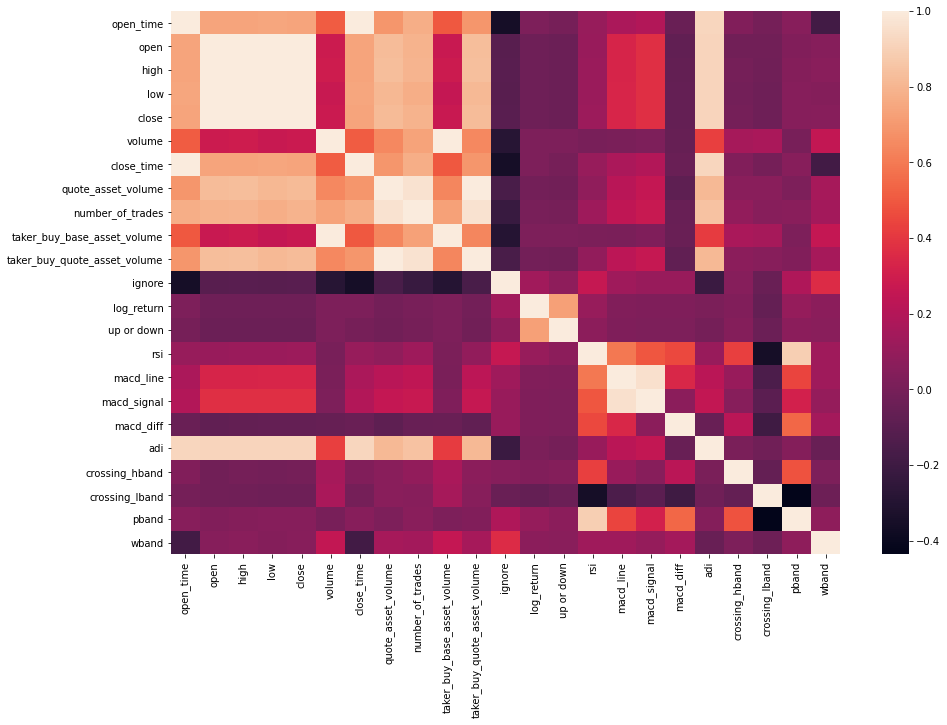

In [6]:
from seaborn import heatmap


feature_corr_matrix = btc_df.corr()
plt.figure(figsize=(15, 10))
ax = heatmap(feature_corr_matrix, cbar=True)
plt.show()

### Feature selection

In [53]:
threshold = 0.05
ignored_cols = ['ignore', 'log_return']

selected_features = [f for f in feature_corr_matrix.columns \
        if abs(feature_corr_matrix["log_return"].loc[f]) >= threshold and f not in ignored_cols]
btc_df[selected_features].corr()

,up or down,rsi,crossing_lband,pband,wband
up or down,1.000000,0.070396,-0.041036,0.065585,0.062387
rsi,0.070396,1.000000,-0.354416,0.887786,0.131755
crossing_lband,-0.041036,-0.354416,1.000000,-0.436582,-0.033654
pband,0.065585,0.887786,-0.436582,1.000000,0.079178
wband,0.062387,0.131755,-0.033654,0.079178,1.000000


From the above correlation matrix, some technical indicators are very weakly correlating to log return over coming 3 days, best ones are rsi, crossing_lband, pband, wband. 

### Feature scaling

In [8]:
btc_df[selected_features].describe()

,up or down,rsi,crossing_lband,pband,wband
count,1581.000000,1568.000000,1581.000000,1562.000000,1562.000000
mean,0.538267,53.168369,0.046806,0.548916,27.275758
std,0.498691,14.170625,0.211290,0.339346,16.465787
min,0.000000,10.497797,0.000000,-0.480954,3.933451
25%,0.000000,43.517901,0.000000,0.282367,15.321308
50%,1.000000,52.006315,0.000000,0.563704,24.131684
75%,1.000000,62.842698,0.000000,0.824616,35.200423
max,1.000000,93.460719,1.000000,1.527677,97.826963


#### MACD illustration

![MACD illustration](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/MACDpicwiki.gif/350px-MACDpicwiki.gif)

In [9]:
# MACD histogram has a scale effect based on price
# normalize this feature before model fitting
btc_df["normalized_macd_diff"] = btc_df["macd_diff"] / btc_df["close"]

In [10]:
# prepare the function that later on will be used to 
# generate a dataset reflecting the hyperparameters
def generate_params_df(source_df, params):
    df = source_df.copy()
    
    df["up or down"] = (df["close"].map(np.log).shift(periods=-3) > \
                        df["close"].map(np.log)).astype(int)
    df = add_technical_indicators(df, *params)
    
    return df[selected_features].dropna(axis=0)

### Train/Test split

We split the data to train/test sets, where the train is used for base model fitting with a set of hyperparameter (explained below), test set prevent us from **overfitting**. 

In [11]:
def train_test_split(df, training_size=0.7):
    target_str = 'up or down'
    train_end = int(len(df) * training_size)
    
    train_df = df.iloc[:train_end, :]
    X_train = train_df[[x for x in train_df.columns if x != target_str]]
    Y_train = train_df[target_str]

    test_df = df.iloc[train_end:, :]
    X_test = test_df[[x for x in test_df.columns if x != target_str]]
    Y_test = test_df[target_str]
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = train_test_split(btc_df)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1106, 24)
(1106,)
(475, 24)
(475,)


### Hyperparameters from technical indicators

In [12]:
rsi_windows = (9, 14, 19)
macd_windows_slow = (21, 26, 31) 
macd_windows_fast = (7, 12, 17) 
macd_windows_sign = (4, 9, 14) 
bollinger_windows = (15, 20, 25) 
bollinger_windows_dev = (2, 4, 6)


from itertools import product


all_hyperparams = list(product(rsi_windows, 
                    macd_windows_slow, 
                    macd_windows_fast, 
                    macd_windows_sign, 
                    bollinger_windows, 
                    bollinger_windows_dev, 
                    ))
print(f"{len(all_hyperparams)} sets of hyperparameters. ")

729 sets of hyperparameters. 


### Optimization metric definition

In [13]:
from sklearn.metrics import accuracy_score


def acc_score(y_truth, y_predicted):
    return accuracy_score(y_truth, y_predicted)

### Model selection

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


cols = ["model", "hyperparams", "train_acc", "test_acc"]
models = [LogisticRegression, SVC, DecisionTreeClassifier, GradientBoostingClassifier]
result_df = pd.DataFrame(columns=cols)

i = 0
trials = len(all_hyperparams) * len(models)
for hyperparams in all_hyperparams:
    # generate dataset parametrized by the set of hyperparam
    params_df = generate_params_df(source_df, hyperparams)
    X_train, Y_train, X_test, Y_test = train_test_split(params_df)
    
    for model in models:
        if model is LogisticRegression:
            classifier = LogisticRegression(random_state=0)
        
        elif model is SVC:
            classifier = SVC(random_state=0)
            
        elif model is DecisionTreeClassifier:
            classifier = DecisionTreeClassifier(random_state=0)

        elif model is GradientBoostingClassifier:
            classifier = GradientBoostingClassifier(random_state=0)
            
        classifier.fit(X_train, Y_train)
        
        train_prediction = classifier.predict(X_train)
        test_prediction = classifier.predict(X_test)

        train_acc = acc_score(Y_train, train_prediction)
        test_acc = acc_score(Y_test, test_prediction)
            
        result_df.loc[len(result_df)] = \
                    [model.__name__, hyperparams, train_acc, test_acc]
        
        i += 1
        print(f"{(i / trials * 100):.1f}% completed. ", end="\r")
    
result_df.sort_values(by=["test_acc"], ascending=False, axis=0)

,model,hyperparams,train_acc,test_acc
2585,SVC,"(19, 26, 17, 14, 25, 4)",0.5427,0.602564
2693,SVC,"(19, 31, 7, 14, 25, 4)",0.5427,0.602564
2369,SVC,"(19, 26, 7, 14, 25, 4)",0.5427,0.602564
2729,SVC,"(19, 31, 12, 4, 25, 4)",0.5427,0.602564
2837,SVC,"(19, 31, 17, 4, 25, 4)",0.5427,0.602564
...,...,...,...,...
2578,DecisionTreeClassifier,"(19, 26, 17, 14, 20, 6)",1.0000,0.464819
2722,DecisionTreeClassifier,"(19, 31, 12, 4, 20, 6)",1.0000,0.464819
2574,DecisionTreeClassifier,"(19, 26, 17, 14, 20, 4)",1.0000,0.464819
1998,DecisionTreeClassifier,"(19, 21, 7, 9, 20, 4)",1.0000,0.464819


### Best model prediction visualization

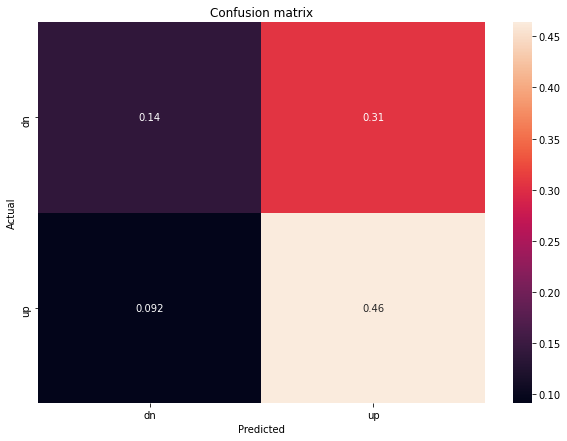

In [47]:
from sklearn.metrics import confusion_matrix


hyperparams = (19, 26, 17, 14, 25, 4)
params_df = generate_params_df(source_df, hyperparams)
X_train, Y_train, X_test, Y_test = train_test_split(params_df)

classifier = SVC(random_state=0)           
classifier.fit(X_train, Y_train)
test_prediction = classifier.predict(X_test)

plt.figure(figsize=(10, 7))
n_predictions = len(Y_test)
confusion_mat_df = pd.DataFrame(confusion_matrix(Y_test, test_prediction), \
                                    index=["dn", "up"], columns=["dn", "up"])
heatmap(confusion_mat_df / n_predictions, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

In [27]:
# out-sample starting date
source_df["datetime"].loc[X_train.index[-1] + 1]

'2020-09-03 00:00:00'

### Save model for backtesting

In [48]:
import pickle


# save the model
with open('scti_1.pkl', 'wb') as fid:
    pickle.dump(classifier, fid)    

# load it again
with open('scti_1.pkl', 'rb') as fid:
    classifier_reloaded = pickle.load(fid)

In [49]:
# check model reimported
all(classifier.predict(X_test) == test_prediction)

True